In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import matplotlib.pyplot as plt
import time

In [2]:
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
print(torch._utils)

2.1.0+cu118
0.16.0+cu118
<module 'torch._utils' from 'C:\\Users\\monster\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\torch\\_utils.py'>


In [3]:

batch_size = 128


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def get_accuracy(model, data_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += int((predicted == labels).sum())
    return correct / total


def train_model(model, dataloader, num_epochs, learning_rate):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    for epoch in range(num_epochs):
        start_t = time.time()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            _, predicted = torch.max(outputs.data, 1)
            correct += int((predicted == labels).sum())

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total += len(outputs)

            running_loss += loss.item()
        end_t = time.time()
        print(f'Epoch = {epoch + 1}, Loss = {running_loss / len(dataloader)}, Time = {end_t - start_t}, Accuracy = {correct / total}')

In [6]:
# Результаты экспериментов
results = {}

names = ['resnet18', 'regnet_y_400mf', 'mobilenet_v3_small', 'shufflenet_v2_x1_0']
weights = ['ResNet18_Weights.IMAGENET1K_V1', 'RegNet_Y_400MF_Weights.IMAGENET1K_V2',
           'MobileNet_V3_Small_Weights.IMAGENET1K_V1', 'ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1']
transforms_weight = [models.ResNet18_Weights.IMAGENET1K_V1.transforms(),
              models.RegNet_Y_400MF_Weights.IMAGENET1K_V2.transforms(),
             models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms(),
             models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1.transforms()]
z = tuple(zip(names, weights, transforms_weight))

models_save = {}
learning_rate=0.001
num_epochs=10


In [7]:
# Эксперимент 1: Обновление весов только последних слоев

for model_name, model_weights, transform in z:
    
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    model = getattr(models, model_name)(weights = model_weights)
    
    criterion = None
    optimizer = None
    for param in model.parameters():
        param.requires_grad = False

    if model_name in ['mobilenet_v3_small']:
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 10)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.classifier[-1].parameters(), lr=learning_rate)
    else:
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

    print(model)
    print(f'E 1 - {model_name}')
    models_save[f'E 1 - {model_name}'] = [model, optimizer]
    train_model(model, trainloader, num_epochs, learning_rate)#, criterion, optimizer)
    accuracy = get_accuracy(model, testloader)
    results[f'E 1 - {model_name}'] = accuracy
    print('Test accuracy = {}'.format(accuracy))
print('Finish training')

Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [8]:
# Эксперимент 2: Полное обучение сети

for model_name, model_weights, _ in z:
    transformf = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomCrop(32, padding=4),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testtransform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transformf)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=testtransform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    model = getattr(models, model_name)(weights = model_weights)
    
    criterion = None
    optimizer = None

    if model_name in ['mobilenet_v3_small']:
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, 10)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, 10)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(model)
    print(f'E 2 - {model_name}')
    models_save[f'E 2 - {model_name}'] = [model, optimizer]
    train_model(model, trainloader, num_epochs, learning_rate)#, criterion, optimizer)

    accuracy = get_accuracy(model, testloader)
    
    results[f'E 2 - {model_name}'] = accuracy
    print('Test accuracy = {}'.format(accuracy))
print('Finish training')

Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [9]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU()
        )
    def forward(self, x):
        out = self.block(x)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer2 = nn.Sequential(block(64, 128, 1))#, nn.MaxPool2d(2))
        self.max_pool1 = nn.MaxPool2d(2)

        self.layer3 = nn.Sequential(block(128, 256, 1))#, nn.MaxPool2d(2))
        self.max_pool2 = nn.MaxPool2d(2)
        
        self.layer4 = nn.Sequential(block(256, 256, 1), block(256, 256, 1))

        self.layer5 = nn.Sequential(block(256, 512, 1))#, nn.MaxPool2d(2))
        self.max_pool3 = nn.MaxPool2d(2)

        self.layer6 = nn.Sequential(block(512, 512, 1), block(512, 512, 1))

        self.max_pool4 = nn.MaxPool2d(4)

        #self.linear = nn.Linear(512, num_classes)

        self.lin = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, 10)
        )
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.max_pool1(out)
        out = self.layer3(out)
        out = self.max_pool2(out)
        out1 = self.layer4(out)
        out = out1 + out
        out = self.layer5(out)
        out = self.max_pool3(out)
        out2 = self.layer6(out)
        out = out2 + out
        out = self.max_pool4(out)
        out = self.lin(out)
        return out

In [10]:
net = ResNet(BasicBlock)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer4): Sequential(
    (0): BasicBloc

In [11]:
loadmodel = ResNet(BasicBlock)
loadmodel.load_state_dict(torch.load('modelcopy.pth'))

<All keys matched successfully>

In [12]:
myres = get_accuracy(loadmodel, testloader)
results[f'mymodelresnet'] = myres
models_save[f'mymodelresnet'] = [loadmodel, optimizer]


In [13]:
print('Точность сети на тестовых изображениях: {}'.format(myres))

Точность сети на тестовых изображениях: 0.8631


accuracy [78.71000000000001, 82.39, 77.3, 82.27, 83.21, 71.63000000000001, 78.35, 79.42, 86.31]


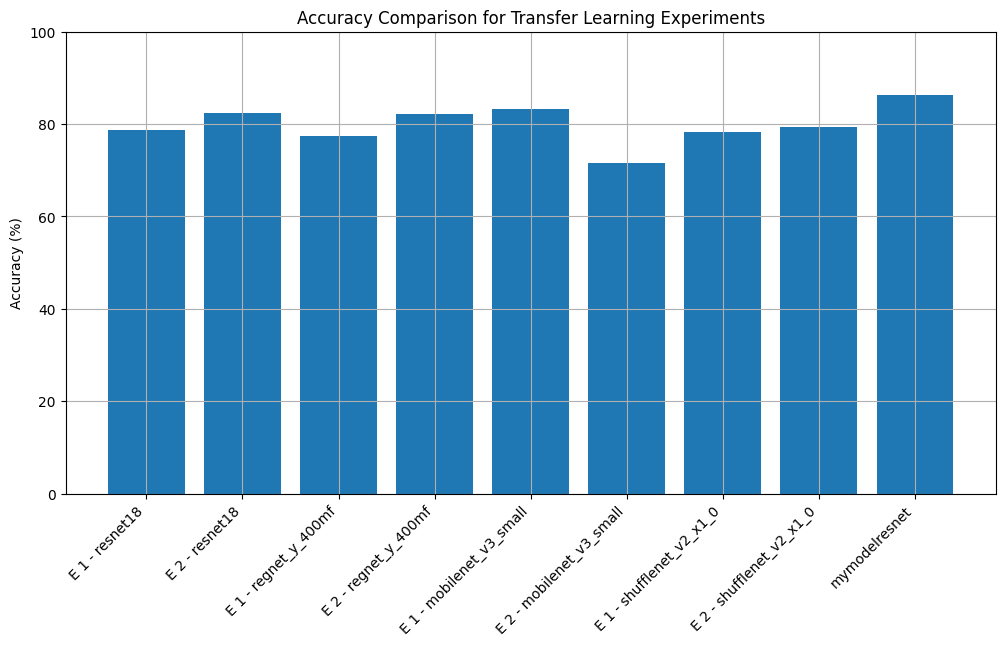

In [37]:
import numpy as np
# Вывод результатов
plt.figure(figsize=(12, 6))

names_bars = list(results.keys())
reskE1 = names_bars[:len(names_bars)//2]
reskE2 = names_bars[len(names_bars)//2:]
cc = []
for pair in zip(reskE1, reskE2):
    cc.extend(pair)
cc.append(names_bars[len(names_bars)-1])

res = [i * 100 for i in list(results.values())]
resE1 = res[:len(res)//2]
resE2 = res[len(res)//2:]
c = []
for pair in zip(resE1, resE2):
    c.extend(pair)
c.append(myres * 100)
print("accuracy",c)

plt.bar(cc, c)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.title('Accuracy Comparison for Transfer Learning Experiments')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()

In [15]:
best_acc_name = max(results, key=results.get)

print(models_save[best_acc_name])
print("Точность на тестовой выборке: ", results[best_acc_name])

[ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): BasicBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer4): Sequential(
    (0): BasicBlo

In [16]:
best_acc_name = max(results, key=results.get)
best_acc_name

'mymodelresnet'

In [ ]:
test_accur = [78.71000000000001, 82.39, 77.3, 82.27, 83.21, 71.63000000000001, 78.35, 79.42, 86.31]